In [97]:
import sys
sys.path.insert(0, '../Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
from pysr import PySRRegressor
import sympy 
import pandas as pd

In [98]:

# Carga los archivos .xlsx
file1 = '../DataExperiments/WT_in_LB_data_s1.XLSX'
file2 = '../DataExperiments/different_conditions_data_s2.XLSX'

# Lee las hojas de los archivos
df1 = pd.read_excel(file1, engine='openpyxl')  # Especifica la hoja si es necesario: sheet_name='nombre_hoja'
df2 = pd.read_excel(file2, engine='openpyxl')

# Cambiar la fila 0 a la nueva cabecera
df2.columns = df2.iloc[0]  # Establecer la primera fila como nueva cabecera
df2 = df2[1:]  # Eliminar la primera fila

# Reiniciar los índices (opcional, si quieres que empiece desde 0)
df2 = df2.reset_index(drop=True)

# Muestra los DataFrames
print("Archivo 1:")
display(df1)

print("Archivo 2:")
display(df2)


Archivo 1:


,Cycle Nr.,Time [s],Temp. [°C],G4,G5,G6,G7,G8,G9,G10,G11,G12,H1,H2,H3,H4,H5,H6
0,1,0.0,30.8,0.0922,0.0928,0.0928,0.0931,0.0928,0.0927,0.0916,0.0921,0.0911,0.0936,0.0925,0.0918,0.0929,0.0931,0.0931
1,2,678.6,30.7,0.0951,0.0957,0.0959,0.0959,0.0957,0.0953,0.0947,0.0951,0.0941,0.0970,0.0958,0.0951,0.0963,0.0963,0.0962
2,3,1357.1,30.4,0.0951,0.0958,0.0957,0.0960,0.0958,0.0954,0.0947,0.0951,0.0943,0.0971,0.0959,0.0952,0.0965,0.0964,0.0963
3,4,2035.7,30.2,0.0955,0.0962,0.0961,0.0965,0.0964,0.0958,0.0950,0.0957,0.0947,0.0975,0.0964,0.0957,0.0969,0.0969,0.0969
4,5,2714.2,30.0,0.0960,0.0969,0.0965,0.0968,0.0968,0.0964,0.0956,0.0963,0.0953,0.0981,0.0969,0.0961,0.0974,0.0973,0.0973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,495,335199.8,30.8,0.8186,0.8214,0.8188,0.8198,0.8221,0.8201,0.8296,0.8418,0.8292,0.4360,0.7711,0.8043,0.8181,0.8181,0.8153
495,496,335878.3,30.9,0.8184,0.8222,0.8185,0.8178,0.8201,0.8182,0.8277,0.8379,0.8274,0.4379,0.7729,0.8038,0.8198,0.8180,0.8154
496,497,336556.8,30.8,0.8183,0.8222,0.8169,0.8204,0.8214,0.8186,0.8287,0.8409,0.8289,0.4304,0.7719,0.8040,0.8187,0.8172,0.8154
497,498,337235.3,30.8,0.8172,0.8211,0.8194,0.8206,0.8227,0.8201,0.8303,0.8417,0.8280,0.4321,0.7717,0.8043,0.8194,0.8173,0.8143


Archivo 2:


,Cycle Nr.,Time [s],Temp. [°C],A1,A2,A3,A4,A5,A6,A7,...,H2,H3,H4,H5,H6,H7,H8,H9,H10,H11
0,1,0,30,0.0929,0.0971,0.0948,0.0961,0.0939,0.0934,0.0938,...,0.0913,0.0914,0.0924,0.0916,0.0925,0.0921,0.092,0.093,0.0927,0.093
1,2,678.6,30.5,0.0925,0.0962,0.0946,0.0953,0.0935,0.0931,0.0933,...,0.0913,0.0916,0.0926,0.092,0.0914,0.0921,0.0921,0.0931,0.0932,0.0925
2,3,1357.2,30.1,0.0926,0.0962,0.095,0.0954,0.0936,0.0932,0.0932,...,0.0916,0.0917,0.0927,0.0918,0.0917,0.0922,0.0923,0.0932,0.0932,0.0927
3,4,2035.8,30,0.0928,0.0981,0.0949,0.0956,0.0937,0.0934,0.0934,...,0.092,0.0921,0.0931,0.0922,0.0922,0.0928,0.0926,0.0936,0.0937,0.093
4,5,2714.4,30.3,0.0933,0.0985,0.0953,0.096,0.0942,0.0939,0.0938,...,0.0925,0.0927,0.0937,0.0928,0.093,0.0933,0.0933,0.0943,0.0944,0.0938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,338,228685.2,29.9,0.5954,0.6453,0.6513,0.6593,0.6599,0.6576,0.5901,...,0.0926,0.0926,0.0935,0.0924,0.0949,1.0018,0.9769,0.9848,0.9871,0.9972
338,339,229363.7,29.8,0.5937,0.6448,0.6495,0.6568,0.6572,0.6564,0.5898,...,0.0926,0.0927,0.0934,0.0926,0.0953,1.0017,0.98,0.9857,0.9868,0.9976
339,340,230042.3,29.9,0.5923,0.6429,0.6487,0.6575,0.6589,0.6572,0.5889,...,0.0925,0.0925,0.0933,0.0923,0.0947,1.0009,0.9758,0.9833,0.9846,0.9963
340,341,230720.9,30.3,0.5912,0.6419,0.6484,0.6568,0.657,0.6548,0.5888,...,0.0923,0.0924,0.0932,0.0921,0.0942,1.0004,0.9763,0.9843,0.9845,0.9981


In [99]:
df2.iloc[:, 9:15]

,A7,A8,A9,A10,A11,A12
0,0.0938,0.0933,0.0947,0.094,0.0945,0.0923
1,0.0933,0.0932,0.0948,0.0937,0.0937,0.0923
2,0.0932,0.0933,0.0948,0.0939,0.0939,0.0927
3,0.0934,0.0935,0.095,0.0941,0.0941,0.0926
4,0.0938,0.0939,0.0954,0.0945,0.0945,0.0929
...,...,...,...,...,...,...
337,0.5901,0.6007,0.5678,0.5227,0.5631,0.308
338,0.5898,0.6002,0.5683,0.5222,0.5616,0.3055
339,0.5889,0.5999,0.5681,0.5221,0.5621,0.3051
340,0.5888,0.5992,0.5675,0.5211,0.561,0.3032


In [100]:
c=-1
P_exp=np.array(df2.iloc[:, 12:13])
T_exp=np.array(df2['Time [s]'])

T_max=max(T_exp)
T_exp=T_exp/max(T_exp)
N_exp=P_exp.shape[1]
N_exp,T_max

(1, 231399.5)

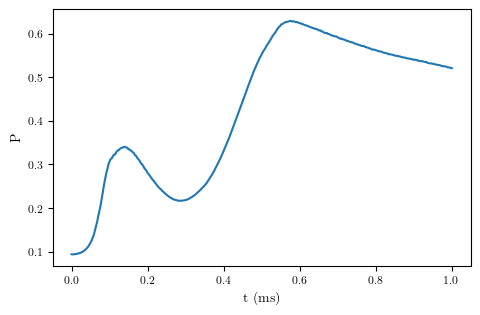

In [101]:
for i in range(N_exp):
    plt.plot(T_exp,P_exp[:, i])
plt.xlabel('t (ms)')
plt.ylabel('P ')
plt.show()

In [102]:
N_f = 300 # Number of residual point
N_d = 300 #Number of data

P_star = P_exp.T.flatten().reshape([-1,1])
T_star = np.tile(T_exp,N_exp).reshape([-1,1])

# Doman bounds
lb = T_star.min(0)
ub = T_star.max(0) 

# Initial Condition
xx1 = T_star[::len(T_exp)]
uu1 = P_star[::len(T_exp)]

# Additional data
idx = np.random.choice(P_star.shape[0], N_d-len(uu1), replace=False)
xxd = T_star[idx]
uud = P_star[idx]

T_u_train = np.concatenate((xx1,xxd)).reshape([-1,1])
p_train = np.concatenate((uu1,uud)).reshape([-1,1])

T_f_train = lb + (ub-lb)*lhs(1, N_f)

T_u_train_tf = tf.convert_to_tensor(T_u_train, dtype=tf.float32)
p_train_tf =   tf.convert_to_tensor(p_train, dtype=tf.float32)
T_f_train_tf = tf.convert_to_tensor(T_f_train, dtype=tf.float32)
P_star_tf = tf.convert_to_tensor(P_star, dtype=tf.float32)

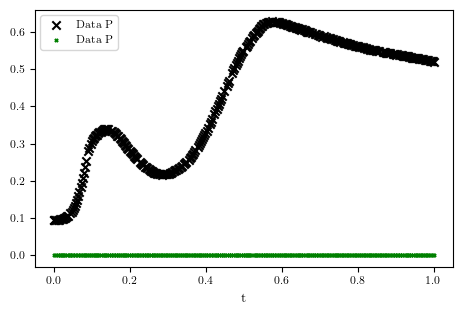

In [103]:
plt.scatter(T_u_train, p_train, marker='x', color='black',label='Data P')
plt.scatter(T_f_train_tf, np.zeros_like(T_f_train_tf), s=5, marker='x', color='green',label='Data P')


plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

In [104]:
np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
#os.environ[‘TF_ENABLE_AUTO_MIXED_PRECISION’] = ‘1’



# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = 2.0*(X - lb)/(ub - lb) - 1.0
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b 

def train_vars_total(W, b, lambda_r, lambda_b):
    return W + b + lambda_r + lambda_b

def net(t, w, b):
    p = DNN(t, w, b)
    return p

def loss_weight(N_r, N_b):
    alpha_b = tf.Variable(tf.reshape(tf.repeat(1000.0, N_b), (N_b, -1))) 
    alpha_r = tf.Variable(tf.ones(shape=[N_r, 1]), dtype=tf.float32)
    alpha_s = tf.Variable(tf.ones(shape=[N_r, 1]), dtype=tf.float32)
    alpha_a = tf.Variable(tf.ones(shape=[N_r, 1]), dtype=tf.float32)

    return alpha_r, alpha_b, alpha_s, alpha_a

#@tf.function(jit_compile=True)
@tf.function()
def net_f(t, lnms1, lnms2, lnma, lnrm, lnrs1, lnrs2, lnra, W_p, b_p):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([t])
        u=net(t, W_p, b_p)

        lnp=u[:,0:1]
        lns1=u[:,1:2]
        lns2=u[:,2:3]
        lna=u[:,3:4]

        p=tf.exp(lnp)
        s1=tf.exp(lns1)
        s2=tf.exp(lns2)
        a=tf.exp(lna)
        ms1=tf.exp(lnms1)[0]
        ms2=tf.exp(lnms2)[0]
        ma=tf.exp(lnma)[0]
        rs1=tf.exp(lnrs1)[0]
        rs2=tf.exp(lnrs2)[0]
        rm=tf.exp(lnrm)[0]
        ra=tf.exp(lnra)[0]


        p_t=tape1.gradient(p, t)
        s1_t=tape1.gradient(s1, t)
        s2_t=tape1.gradient(s2, t)
        a_t=tape1.gradient(a, t)


    f_p = p_t - rs1[0]*s1*p - rs2[0]*s2*p + ra[0]*a*p + rm[0]*p
    f_s1 = s1_t + ms1[0]*p*s1
    f_s2 = s2_t + ms2[0]*p*s2
    f_a = a_t + ma[0]*p*a

    return f_p, f_s1, f_s2, f_a


#@tf.function()
@tf.function()
def train_step(W_p, b_p, X_u_train_tf, p_train_tf, X_f_train_tf, lambda_r, lambda_b, lambda_s, lambda_a, lnms1, lnms2, lnma, lnrm, lnrs1, lnrs2, lnra, opt):
    
    t_u = X_u_train_tf
    t_f = X_f_train_tf

    with tf.GradientTape(persistent=True) as tape:
        tape.watch([W_p, b_p, lnms1, lnms2, lnma, lnrm, lnrs1, lnrs2, lnra, lambda_r, lambda_b, lambda_s, lambda_a])
        u_nn = net(t_u, W_p, b_p) 
        lnp=u_nn[:,0:1]
        p_nn=tf.exp(lnp)
        u_nn_0 = net(tf.zeros([1,1], dtype=tf.float32), W_p, b_p) 
        s1_0=tf.exp(u_nn_0[:,1:2])
        s2_0=tf.exp(u_nn_0[:,2:3])
        a_0=tf.exp(u_nn_0[:,3:4])

        f_p, f_s1, f_s2, f_a = net_f(t_f,lnms1, lnms2, lnma, lnrm, lnrs1, lnrs2, lnra, W_p, b_p)

        loss_p = tf.square(lambda_b*(p_nn - p_train_tf))
        loss_s10 = tf.square(lambda_b*(1 - s1_0))
        loss_s20 = tf.square(lambda_b*(1 - s2_0))
        loss_a0 = tf.square(lambda_b*(1 - a_0))
        loss_fp = tf.square(lambda_r*f_p) 
        loss_fs1 = tf.square(lambda_s*f_s1) 
        loss_fs2 = tf.square(lambda_s*f_s2) 
        loss_fa = tf.square(lambda_a*f_a) 

        loss =  tf.reduce_mean(loss_p) + tf.reduce_mean(loss_s10) + tf.reduce_mean(loss_s20) + tf.reduce_mean(loss_a0) + tf.reduce_mean(loss_fp)+ tf.reduce_mean(loss_fs1) + tf.reduce_mean(loss_fs2) + tf.reduce_mean(loss_fa)
        # loss =  tf.reduce_mean(loss_p) + tf.reduce_mean(loss_fp)+ tf.reduce_mean(loss_fs1) + tf.reduce_mean(loss_fs2) + tf.reduce_mean(loss_fa)

    grads_p = tape.gradient(loss, train_vars(W_p, b_p))

    grads_ms1 = tape.gradient(loss, lnms1)
    grads_ms2 = tape.gradient(loss, lnms2)
    grads_ma = tape.gradient(loss, lnma)
    grads_rm = tape.gradient(loss, lnrm)
    grads_rs1 = tape.gradient(loss, lnrs1)
    grads_rs2= tape.gradient(loss, lnrs2)
    grads_ra = tape.gradient(loss, lnra)
    grads_la = tape.gradient(loss, lambda_a)
    grads_ls = tape.gradient(loss, lambda_s)
    grads_lr = tape.gradient(loss, lambda_r)
    grads_lb = tape.gradient(loss, lambda_b)




    # grads_m = tape.gradient(loss, m)

    opt.apply_gradients(zip(grads_p, train_vars(W_p, b_p)))
    opt.apply_gradients(zip(grads_ms1, lnms1))
    opt.apply_gradients(zip(grads_ms2, lnms2))
    opt.apply_gradients(zip(grads_ma, lnma))
    opt.apply_gradients(zip(grads_rs1, lnrs1))
    opt.apply_gradients(zip(grads_rs2, lnrs2))
    opt.apply_gradients(zip(grads_rm, lnrm))
    opt.apply_gradients(zip(grads_ra, lnra))
    opt.apply_gradients(zip([-grads_la], [lambda_a]))
    opt.apply_gradients(zip([-grads_ls], [lambda_s]))
    opt.apply_gradients(zip([-grads_lr], [lambda_r]))
    opt.apply_gradients(zip([-grads_lb], [lambda_b]))




    # opt.apply_gradients(zip(grads_m, m))
   
    return loss, tf.reduce_mean(loss_p), tf.reduce_mean(loss_fp), tf.reduce_mean(loss_fs1), tf.reduce_mean(loss_fs2), tf.reduce_mean(loss_fa)



layers = [1, 50, 50, 4]

L = len(layers)
W_p = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_p = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]


lambda_r, lambda_b, lambda_s, lambda_a = loss_weight(N_f, N_d)
lnms1 = [tf.Variable(tf.ones([1,1]), dtype=tf.float32)]
lnms2 = [tf.Variable(tf.ones([1,1]), dtype=tf.float32)]
lnma = [tf.Variable(tf.ones([1,1]), dtype=tf.float32)]
lnra = [tf.Variable(tf.ones([1,1]), dtype=tf.float32)]
lnrs1 = [tf.Variable(tf.ones([1,1]), dtype=tf.float32)]
lnrs2 = [tf.Variable(tf.ones([1,1]), dtype=tf.float32)]
lnrm = [tf.Variable(tf.ones([1,1]), dtype=tf.float32)]


In [105]:
lr = 1e-3
# Nmax = 15000
Nmax = 150000
Nmax=10**5
# Nmax=60000



optimizer = tf.optimizers.Adam(learning_rate=lr)

start_time = time.time()
n=0
loss = []
loss_p = []
loss_fp = []
loss_fs1 = []
loss_fs2 = []

loss_fa = []


while n <= Nmax:
    loss_, loss_p_, loss_fp_, loss_fs1_, loss_fs2_, loss_fa_ = train_step(W_p, b_p, T_u_train_tf, p_train_tf, T_f_train_tf, lambda_r, lambda_b, lambda_s, lambda_a, lnms1, lnms2, lnma, lnrm, lnrs1, lnrs2, lnra, optimizer)
    
    loss.append(loss_)
    loss_p.append(loss_p_)
    loss_fp.append(loss_fp_)
    loss_fs1.append(loss_fs1_)
    loss_fs2.append(loss_fs2_)

    loss_fa.append(loss_fa_)



    if n % 10 == 0:
        print(f"Iteration is: {n}")
        print(f"Total loss is: {loss_}")

        print(f"Data loss is: {loss_p_}")
        print(f"Physicial loss of p is: {loss_fp_}")
        print(f"Physicial loss of s is: {loss_fs1_}")
        print(f"Physicial loss of a is: {loss_fa_}")


    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

Iteration is: 0
Total loss is: 367959.75
Data loss is: 346061.34375
Physicial loss of p is: 0.15243682265281677
Physicial loss of s is: 8.038272857666016
Physicial loss of a is: 8.848389625549316
Iteration is: 10
Total loss is: 170117.09375
Data loss is: 167061.84375
Physicial loss of p is: 0.07300986349582672
Physicial loss of s is: 4.974963188171387
Physicial loss of a is: 6.173101425170898
Iteration is: 20
Total loss is: 16303.916015625
Data loss is: 15066.853515625
Physicial loss of p is: 0.0016021113842725754
Physicial loss of s is: 1.7457655668258667
Physicial loss of a is: 2.797626256942749
Iteration is: 30
Total loss is: 23447.669921875
Data loss is: 22782.4609375
Physicial loss of p is: 0.058086782693862915
Physicial loss of s is: 0.9116265773773193
Physicial loss of a is: 1.99964439868927
Iteration is: 40
Total loss is: 19032.3515625
Data loss is: 18816.197265625
Physicial loss of p is: 0.03611771762371063
Physicial loss of s is: 1.0873520374298096
Physicial loss of a is: 2.2

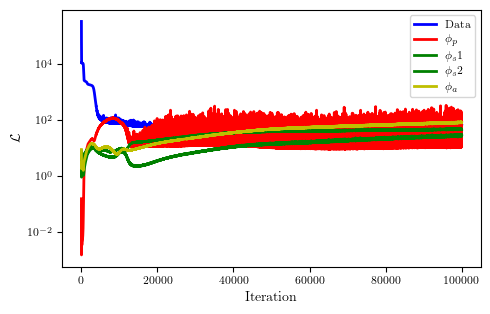

In [106]:
it = np.arange(0,Nmax, 1)
loss_list = [loss[i].numpy() for i in range(0,Nmax)]
loss_p_list = [loss_p[i].numpy() for i in range(0,Nmax)]
loss_fp_list = [loss_fp[i].numpy() for i in range(0,Nmax)]
loss_fs1_list = [loss_fs1[i].numpy() for i in range(0,Nmax)]
loss_fs2_list = [loss_fs2[i].numpy() for i in range(0,Nmax)]

loss_fa_list = [loss_fa[i].numpy() for i in range(0,Nmax)]


plt.semilogy(it, np.asarray(loss_p_list), 'b-', linewidth = 2, label = 'Data')  
plt.semilogy(it, np.asarray(loss_fp_list), 'r-', linewidth = 2, label = '$\phi_p$')    
plt.semilogy(it, np.asarray(loss_fs1_list), 'g-', linewidth = 2, label = '$\phi_s1$')  
plt.semilogy(it, np.asarray(loss_fs2_list), 'g-', linewidth = 2, label = '$\phi_s2$')    
plt.semilogy(it, np.asarray(loss_fa_list), 'y-', linewidth = 2, label = '$\phi_a$')       



plt.xlabel('Iteration')
plt.ylabel('$\mathcal{L}$')  
plt.legend()  
# plt.savefig('figures/loss_phi.pdf')
plt.show()

In [107]:
ms1=tf.exp(lnms1)[0]
ms2=tf.exp(lnms2)[0]
ma=tf.exp(lnma)[0]
rs1=tf.exp(lnrs1)[0]
rs2=tf.exp(lnrs2)[0]
ra=tf.exp(lnra)[0]
rm=tf.exp(lnrm)[0]

In [108]:
ms1,ms2, ma, rs1, rs2, ra, rm

(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[9.082084]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.6558]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[4.8545747]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[160.4875]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[200.50562]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[275.01367]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[69.902695]], dtype=float32)>)

In [109]:
def predict(X_star_tf, w, b):
    u_pred = net(X_star_tf, w, b)
    return u_pred

## Evaluating total function
T_star_tf = tf.convert_to_tensor(T_star[:len(T_exp)], dtype=tf.float32)    
u_pred = predict(T_star_tf, W_p, b_p)

# ## Evaluating unknown function
lnp=u_pred[:,0:1]
lns1=u_pred[:,1:2]
lns2=u_pred[:,2:3]
lna=u_pred[:,3:4]

p=tf.exp(lnp)
s1=tf.exp(lns1)
s2=tf.exp(lns2)
a=tf.exp(lna)
# phi_p = predict(tf.concat([p, s, a],1), W_phip, b_phip)
# phi_a = predict(tf.concat([p, a],1), W_phia, b_phia)
phi_p= rs1*s1*p + rs2*s2*p - ra*a*p - rm*p
phi_s1=-ms1*s1*p
phi_s2=-ms2*s2*p
phi_a=-ma*a*p


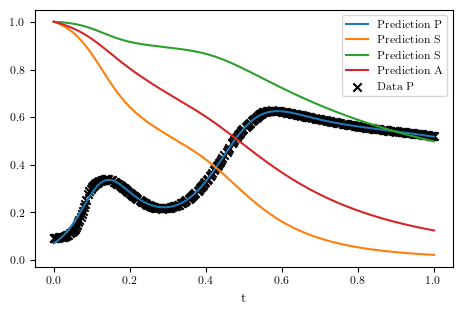

In [110]:
plt.plot(T_star_tf, p, label='Prediction P')
plt.plot(T_star_tf, s1, label='Prediction S')
plt.plot(T_star_tf, s2, label='Prediction S')
plt.plot(T_star_tf, a, label='Prediction A')


# for i in range(N_exp):
#     plt.plot(T_star[i*len(T_exp):(i+1)*len(T_exp)],P_star[i*len(T_exp):(i+1)*len(T_exp)],linestyle=':')

plt.scatter(T_u_train, p_train, marker='x', color='black',label='Data P')

plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

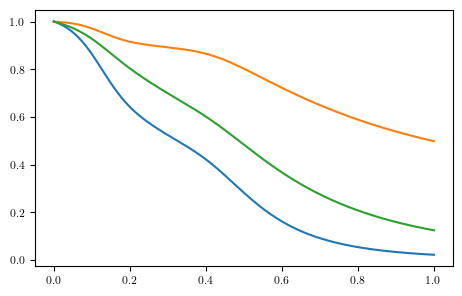

In [111]:
plt.plot(T_star_tf, s1, label='Prediction S1')
plt.plot(T_star_tf, s2, label='Prediction S2')
plt.plot(T_star_tf, a, label='Prediction A')
plt.show()


In [112]:
Nt=10000
T_int=np.zeros(Nt)
P_int=np.zeros(Nt)
S1_int=np.zeros(Nt)
S2_int=np.zeros(Nt)
A_int=np.zeros(Nt)

dt=0.0001
T_int[0]=0
for i in range(1,Nt):
    T_int[i]=T_int[i-1]+dt
    
P_int[0]=np.array(p[0]) #Initial conditions
PRE=predict(tf.convert_to_tensor(T_int.reshape([-1,1]), dtype=tf.float32), W_p, b_p)
S1_int=tf.exp(PRE[:,1:2])
S2_int=tf.exp(PRE[:,2:3])
A_int=tf.exp(PRE[:,3:4])

for i in range(1,Nt):
    P_int[i]=P_int[i-1]+P_int[i-1]*(rs1[0]*S1_int[i-1]+rs2[0]*S2_int[i-1]-ra[0]*A_int[i-1]-rm[0])*dt


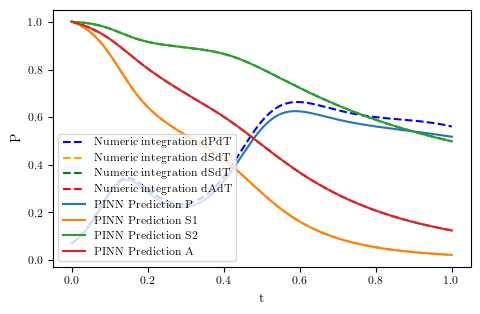

In [113]:
plt.plot(T_int, P_int, color='blue', linestyle='--', label='Numeric integration dPdT')
plt.plot(T_int, S1_int, color='orange', linestyle='--', label='Numeric integration dSdT')
plt.plot(T_int, S2_int, color='green', linestyle='--', label='Numeric integration dSdT')
plt.plot(T_int, A_int, color='red', linestyle='--', label='Numeric integration dAdT')


plt.plot(T_star_tf, p, label='PINN Prediction P')
plt.plot(T_star_tf, s1, label='PINN Prediction S1')
plt.plot(T_star_tf, s2, label='PINN Prediction S2')

plt.plot(T_star_tf, a, label='PINN Prediction A')

plt.xlabel('t')
plt.ylabel('P')
plt.legend()
plt.show()

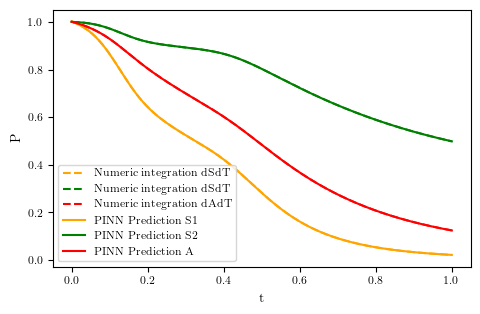

In [114]:
# plt.plot(T_int, P_int, color='blue', linestyle='--', label='Numeric integration dPdT')
plt.plot(T_int, S1_int, color='orange', linestyle='--', label='Numeric integration dSdT')
plt.plot(T_int, S2_int, color='green', linestyle='--', label='Numeric integration dSdT')
plt.plot(T_int, A_int, color='red', linestyle='--', label='Numeric integration dAdT')


# plt.plot(T_star_tf, p, label='PINN Prediction P')
plt.plot(T_star_tf, s1,color='orange', label='PINN Prediction S1')
plt.plot(T_star_tf, s2, color='green',label='PINN Prediction S2')

plt.plot(T_star_tf, a, color='red', label='PINN Prediction A')

plt.xlabel('t')
plt.ylabel('P')
plt.legend()

In [115]:
Nt=10000
T_int=np.zeros(Nt)
P_int=np.zeros(Nt)
S1_int=np.zeros(Nt)
S2_int=np.zeros(Nt)
A_int=np.zeros(Nt)

dt=0.0001
T_int[0]=0
P_int[0]=np.array(p[0])
S1_int[0]=np.array(s1[0])
S2_int[0]=np.array(s2[0])
A_int[0]=np.array(a[0])

for i in range(1,Nt):
    P_int[i]=P_int[i-1]+P_int[i-1]*(rs1[0]*S1_int[i-1]+rs2[0]*S2_int[i-1]-ra[0]*A_int[i-1]-rm[0])*dt
    S1_int[i]=S1_int[i-1]-S1_int[i-1]*ms1[0]*P_int[i-1]*dt
    S2_int[i]=S2_int[i-1]-S2_int[i-1]*ms2[0]*P_int[i-1]*dt
    A_int[i]=A_int[i-1]-A_int[i-1]*ma[0]*P_int[i-1]*dt
    T_int[i]=T_int[i-1]+dt



In [116]:
A_int

array([1.00101519, 1.00098109, 1.00094688, ..., 0.45558208, 0.45557985,
       0.45557761])

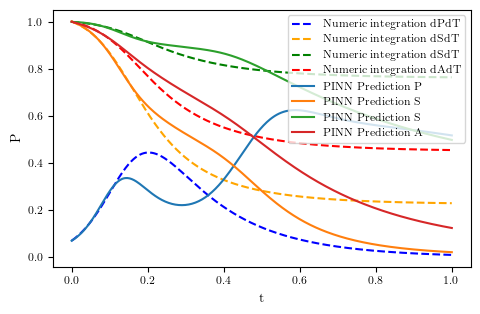

In [117]:
plt.plot(T_int, P_int, color='blue', linestyle='--', label='Numeric integration dPdT')
plt.plot(T_int, S1_int, color='orange', linestyle='--', label='Numeric integration dSdT')
plt.plot(T_int, S2_int, color='green', linestyle='--', label='Numeric integration dSdT')

plt.plot(T_int, A_int, color='red', linestyle='--', label='Numeric integration dAdT')



plt.plot(T_star_tf, p, label='PINN Prediction P')
plt.plot(T_star_tf, s1, label='PINN Prediction S')
plt.plot(T_star_tf, s2, label='PINN Prediction S')
plt.plot(T_star_tf, a, label='PINN Prediction A')

plt.xlabel('t')
plt.ylabel('P')
plt.legend()
plt.show()

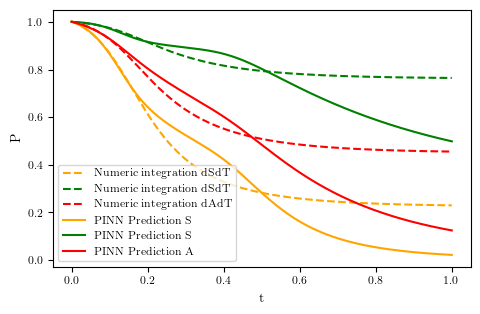

In [118]:
# plt.plot(T_int, P_int, color='blue', linestyle='--', label='Numeric integration dPdT')
plt.plot(T_int, S1_int, color='orange', linestyle='--', label='Numeric integration dSdT')
plt.plot(T_int, S2_int, color='green', linestyle='--', label='Numeric integration dSdT')

plt.plot(T_int, A_int, color='red', linestyle='--', label='Numeric integration dAdT')



# plt.plot(T_star_tf, p, label='PINN Prediction P')
plt.plot(T_star_tf, s1, color='orange', label='PINN Prediction S')
plt.plot(T_star_tf, s2, color='green', label='PINN Prediction S')
plt.plot(T_star_tf, a,color='red', label='PINN Prediction A')

plt.xlabel('t')
plt.ylabel('P')
plt.legend()
plt.show()